In [1]:
!pip install git+https://github.com/Flofega/NNucleate.git

  Cloning https://github.com/Flofega/NNucleate.git to /tmp/pip-req-build-_mkq6zma
  Running command git clone -q https://github.com/Flofega/NNucleate.git /tmp/pip-req-build-_mkq6zma
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.2 MB 4.2 MB/s 
     |████████████████████████████████| 3.4 MB 45.8 MB/s 
     |████████████████████████████████| 2.3 MB 35.6 MB/s 
     |████████████████████████████████| 2.0 MB 15.3 MB/s 
     |████████████████████████████████| 334 kB 59.6 MB/s 
  Created wheel for NNucleate: filename=NNucleate-0.0.1-py3-none-any.whl size=10956 sha256=540d54b24c6c4841c5312168207293ae84cb5b017c13e5ad39985468e9c07585
  Stored in directory: /tmp/pip-ephem-wheel-cache-_l0lqu7h/wheels/44/6d/1b/ae654aec4ee2888c1de63303dd425d120ea950760fd6f9c48a
  Created wheel for MDAnalysis: filename=MDAnalysis-2.0.0-cp37-cp37m-linux_x86_64.whl size=4486239 sha256=611c4b8a25c4d2e

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
path = "drive/MyDrive/Permutational_Invariance/"

In [4]:
import NNucleate
import math
from torch.optim import optimizer
import NNucleate
from NNucleate.trainig import test, train, NNCV, CVTrajectory, NdistTrajectory, KNNTrajectory
from NNucleate.data_augmentaion import transform_frame_to_knn_list, transform_frame_to_ndist_list
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader

Using cpu device


/usr/local/lib/python3.7/dist-packages/mdtraj/formats/pdb/pdbfile.py:194: RuntimeWarning: divide by zero encountered in true_divide
  particle_density = traj.top.n_atoms / traj.unitcell_volumes[0]
/usr/local/lib/python3.7/dist-packages/mdtraj/formats/pdb/pdbfile.py:198: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  'cell vectors.', category=UserWarning)


Epoch 1
 ------------------------------
loss: 62.582962 [    0/ 8001]
Avg. Test loss: 59.426964 

Epoch 2
 ------------------------------
loss: 45.909882 [    0/ 8001]
Avg. Test loss: 60.223130 

Epoch 3
 ------------------------------
loss: 62.236546 [    0/ 8001]
Avg. Test loss: 59.297230 

Epoch 4
 ------------------------------
loss: 38.771393 [    0/ 8001]
Avg. Test loss: 58.086631 

Epoch 5
 ------------------------------
loss: 75.697784 [    0/ 8001]
Avg. Test loss: 56.917514 

Epoch 6
 ------------------------------
loss: 72.395081 [    0/ 8001]
Avg. Test loss: 47.277336 

Epoch 7
 ------------------------------
loss: 50.828556 [    0/ 8001]
Avg. Test loss: 37.525096 

Epoch 8
 ------------------------------
loss: 37.767403 [    0/ 8001]
Avg. Test loss: 30.994624 

Epoch 9
 ------------------------------
loss: 22.038294 [    0/ 8001]
Avg. Test loss: 25.621603 

Epoch 10
 ------------------------------
loss: 34.219051 [    0/ 8001]
Avg. Test loss: 23.066331 

Epoch 11
 ---------

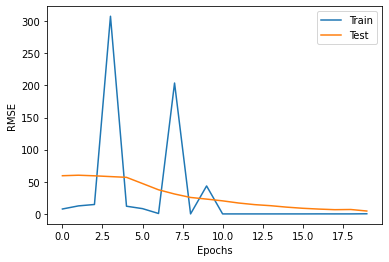

In [ ]:


# Train a model on the trajectory 13 with 5000 dist and 5 neighbours
# Get a cpu or GPU for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Necessary files
traj_path = path + "trajectories/dump.3Dcolloid.13.xyz"
cv_path = path + "trajectories/cn.13.dat"
top_path = path + "trajectories/reference_13.pdb"

# Start with n_dist
n_at = 421
n_dist = int(n_at*(n_at-1)/2)
mod_fun = lambda x: transform_frame_to_ndist_list(n_dist, x, [92.83, 92.83, 92.83, 90.0, 90.0, 90.0]) 
ds = CVTrajectory(cv_path, traj_path, top_path, 3, 92.83, transform = mod_fun)
train_set, test_set = torch.utils.data.random_split(ds, [int(len(ds)*0.8)+1, int(len(ds)*0.2)])

# Create the wrappers
train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)

epochs = 20
learning_rate = 1e-4
loss_fn = nn.MSELoss()
n_at = 421

# The model
model_1 = NNCV(n_dist, 512, 256, 128).to(device) 
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)

train_errors = []
test_errors = []

for t in range(epochs):
    print(f"Epoch {t+1}\n ------------------------------")
    tr = train(train_dataloader, model_1, loss_fn, optimizer, device, 500)
    train_errors.append(tr)
    te = test(test_dataloader, model_1, loss_fn, device)
    test_errors.append(te)

plt.plot(train_errors, label="Train")
plt.plot(test_errors, label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.show()

## Timimng of the kNN approach

In [5]:
%%time
# Train a model on the trajectory 13 with 5000 dist and 5 neighbours
# Get a cpu or GPU for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Necessary files
traj_path = path + "trajectories/dump.3Dcolloid.13.xyz"
cv_path = path + "trajectories/cn.13.dat"
top_path = path + "trajectories/reference_13.pdb"

# Start with n_dist
k = 12
# The critical difference
ds = KNNTrajectory(cv_path, traj_path, top_path, 3, [92.83, 92.83, 92.83], k)
train_set, test_set = torch.utils.data.random_split(ds, [int(len(ds)*0.8)+1, int(len(ds)*0.2)])

Using cpu device


/usr/local/lib/python3.7/dist-packages/mdtraj/formats/pdb/pdbfile.py:194: RuntimeWarning: divide by zero encountered in true_divide
  particle_density = traj.top.n_atoms / traj.unitcell_volumes[0]
/usr/local/lib/python3.7/dist-packages/mdtraj/formats/pdb/pdbfile.py:198: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  'cell vectors.', category=UserWarning)


CPU times: user 56min 38s, sys: 12.1 s, total: 56min 51s
Wall time: 56min 47s


Epoch 1
 ------------------------------
loss: 57.767944 [    0/ 8001]
Avg. Test loss: 57.291103 

Epoch 2
 ------------------------------
loss: 56.491028 [    0/ 8001]
Avg. Test loss: 57.350607 

Epoch 3
 ------------------------------
loss: 61.266544 [    0/ 8001]
Avg. Test loss: 56.686605 

Epoch 4
 ------------------------------
loss: 77.822998 [    0/ 8001]
Avg. Test loss: 56.811481 

Epoch 5
 ------------------------------
loss: 69.185318 [    0/ 8001]
Avg. Test loss: 55.999459 

Epoch 6
 ------------------------------
loss: 57.235275 [    0/ 8001]
Avg. Test loss: 55.627626 

Epoch 7
 ------------------------------
loss: 62.616058 [    0/ 8001]
Avg. Test loss: 55.019290 

Epoch 8
 ------------------------------
loss: 68.205559 [    0/ 8001]
Avg. Test loss: 53.391366 

Epoch 9
 ------------------------------
loss: 59.728588 [    0/ 8001]
Avg. Test loss: 49.289504 

Epoch 10
 ------------------------------
loss: 68.323112 [    0/ 8001]
Avg. Test loss: 43.226424 

Epoch 11
 ---------

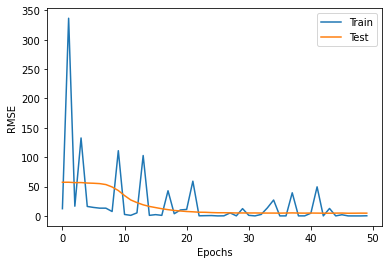

In [6]:
# Create the wrappers
train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)

epochs = 50
learning_rate = 1e-4
loss_fn = nn.MSELoss()
n_at = 421

# The model
model_2 = NNCV(int(math.ceil(n_at*k/2)), 512, 256, 128).to(device) 
optimizer = torch.optim.Adam(model_2.parameters(), lr=learning_rate)

train_errors = []
test_errors = []

for t in range(epochs):
    print(f"Epoch {t+1}\n ------------------------------")
    tr = train(train_dataloader, model_2, loss_fn, optimizer, device, 500)
    train_errors.append(tr)
    te = test(test_dataloader, model_2, loss_fn, device)
    test_errors.append(te)

plt.plot(train_errors, label="Train")
plt.plot(test_errors, label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.show()